# Thematic modelling

In [ ]:
import pandas as pd
import ast
from ast import literal_eval
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
def read_data(path, sep):
    df = pd.read_csv(path, sep=sep)
    df.loc[:, 'AA'] = df['AA'].apply(lambda x: ast.literal_eval(x))
    df.loc[:, 'W'] = df['W'].apply(lambda x: ast.literal_eval(x))
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = read_data('drive/MyDrive/filtered_data.csv', sep = ';')

In [ ]:
# df = pd.read_csv('filtered_data.csv', sep = ';')

In [ ]:
df.loc[:, 'IA'] = df['IA'].apply(lambda x: ast.literal_eval(x))
df.loc[:, 'AW'] = df['AW'].apply(lambda x: ast.literal_eval(x))


In [ ]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 86.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=18ff83f48a8c489876df32dc8202699c31e60cc2a28bafce50bc992f3576bfe4
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


## All words

In [ ]:
from pymystem3 import Mystem
import pymorphy2
from nltk.corpus import stopwords
import re
import gensim
import logging
import nltk.data 
import urllib.request
from bs4 import BeautifulSoup
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

morph = pymorphy2.MorphAnalyzer()

def lemmatize(words):
    # words = text.split()
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

def preprocess(text, remove_stopwords=True):
    text = re.sub("[^a-zA-Z]"," ", text)
    text = lemmatize(text.split())
    words = [word.lower() for word in text]
    if remove_stopwords:
        stops = stopwords.words("english")
        words = [w for w in words if not w in stops and len(w) > 1]
    return(words)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
for i in tqdm(range(len(df))):
    annotation = ''
    for key, value in df.loc[i, 'IA']['InvertedIndex'].items():
        annotation += (key + ' ') * len(value)
    clean_words = lemmatize(df['AW'][i])
    # print(clean_words)
    # print(preprocess(annotation))
    clean_annotation = list(filter(lambda x: x in clean_words, preprocess(annotation)))
    df.loc[[i], 'clean_annotation'] = pd.Series([' '.join(clean_annotation)], index=df.index[[i]])
    # break


  0%|          | 0/39811 [00:00<?, ?it/s]

In [ ]:
df['clean_annotation'] = df['clean_annotation'].apply(lambda x: x.split())

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

common_dictionary = Dictionary(df['clean_annotation'])
common_corpus = [common_dictionary.doc2bow(text) for text in df['clean_annotation']]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=common_corpus,
                                           id2word=common_dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.3 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.207858  0.036229       1        1  23.445160
2      0.156362 -0.180498       2        1  21.713848
0      0.124603  0.265116       3        1  19.540817
1     -0.167933  0.047328       4        1  17.743159
4      0.239611 -0.035594       5        1   9.904596
5     -0.144786 -0.132581       6        1   7.652420, topic_info=           Term           Freq          Total Category  logprob  loglift
227          pd  114036.000000  114036.000000  Default  30.0000  30.0000
114    patients   60599.000000   60599.000000  Default  29.0000  29.0000
1222    induced   15451.000000   15451.000000  Default  28.0000  28.0000
373     protein   14250.000000   14250.000000  Default  27.0000  27.0000
382   synuclein    9293.000000    9293.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
55      factors    1431.599443    6250.142804   Topic6  -5.5858   1.0963
3           age    1447.870557    8010.014852   Topic6  -5.5745   0.8595
97      methods    1547.012759   13762.113059   Topic6  -5.5083   0.3846
494       found    1399.117113    9118.198290   Topic6  -5.6088   0.6957
257         two    1194.541180    8633.666633   Topic6  -5.7669   0.5922

[387 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1893      2  0.221113  accumulation
1893      5  0.778902  accumulation
1083      1  0.002810      accuracy
1083      4  0.997038      accuracy
3134      2  0.345239          acid
...     ...       ...           ...
1507      1  0.992536          year
1507      6  0.007223          year
158       1  0.771976         years
158       3  0.177154         years
158       6  0.050818         years

[626 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5, 6])

In [ ]:
common_dictionary.save('drive/MyDrive/lda_all_dictionary')

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
lda_model.save('drive/MyDrive/lda_all_model')

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# tmp = LdaModel.load('drive/MyDrive/lda_all_model')

In [ ]:
# tmp = Dictionary.load('drive/MyDrive/lda_all_dictionary')

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# type(common_dictionary.id2token)

In [ ]:
# lda_model.get_document_topics(common_corpus[0])

In [ ]:
# lda_model.show_topics()

# Specific words

In [ ]:
biochemical = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'биох-ген-клетка')
medicine = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'лекарства')
symptom = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'симптом')
diagnosis = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'диагноз')
methods = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'методы исследования')
cns = pd.read_excel('drive/MyDrive/все термины по областям.xlsx', sheet_name = 'цнс')

In [ ]:
analogue_dict = dict()

In [ ]:
def parse_words(df):
    words_list = list()
    for i in range(len(df)):
        words_list.append(df.loc[i, 'word'])
        try:
            analogue = df.loc[i, 'analogue'].split(';')
            for word in analogue:
                analogue_dict[word] = df.loc[i, 'word']
            words_list += analogue
        except:
            pass
    return words_list

In [ ]:
biochemical_words = parse_words(biochemical)
medicine_words = parse_words(medicine)
symptom_words = parse_words(symptom)
diagnosis_words = parse_words(diagnosis)
methods_words = parse_words(methods)
cns_words = parse_words(cns)

In [ ]:
all_specific_words = list(set(list(biochemical_words + medicine_words + symptom_words + diagnosis_words + methods_words + cns_words)))

In [ ]:
len(biochemical_words), len(medicine_words), len(symptom_words), len(diagnosis_words), len(methods_words), len(cns_words)

(95, 180, 72, 37, 23, 61)

In [ ]:
for tmp1 in [biochemical_words, medicine_words, symptom_words, diagnosis_words, methods_words, cns_words]:
    for tmp2 in [biochemical_words, medicine_words, symptom_words, diagnosis_words, methods_words, cns_words]:
        if tmp1 != tmp2:
            if len(set(tmp1) & set(tmp2)) != 0:
                print('aaa')
                print(tmp1[:2])
                print(tmp2[:2])
                print(set(tmp1) & set(tmp2))

aaa
['protein', 'proteins']
['stimulation', 'updrs']
{'mibg'}
aaa
['protein', 'proteins']
['brain', 'nigra']
{'gaba', 'extracellular', 'microglia'}
aaa
['alzheimer', 'alzheimers']
['brain', 'nigra']
{'supranuclear'}
aaa
['stimulation', 'updrs']
['protein', 'proteins']
{'mibg'}
aaa
['brain', 'nigra']
['protein', 'proteins']
{'gaba', 'extracellular', 'microglia'}
aaa
['brain', 'nigra']
['alzheimer', 'alzheimers']
{'supranuclear'}


In [ ]:
95+ 180+ 72+ 37+ 23+ 61

468

In [ ]:
len(all_specific_words)

462

In [ ]:
for j in tqdm(range(len(df))):
    clean_annotation = list(filter(lambda x: x in all_specific_words, df['AW'][j]))
    biochemical_flag = 0
    medicine_flag = 0
    symptom_flag = 0 
    diagnosis_flag = 0 
    methods_flag = 0 
    cns_flag = 0
    
    for i, word in enumerate(clean_annotation):
       if word in biochemical_words:
           biochemical_flag = 1
           if word not in biochemical['word'].values:
              clean_annotation[i] = analogue_dict[word]

       if word in medicine_words:
           medicine_flag = 1
           if word not in medicine['word'].values:
              clean_annotation[i] = analogue_dict[word]

       if word in symptom_words:
           symptom_flag = 1
           if word not in symptom['word'].values:
              clean_annotation[i] = analogue_dict[word]

       if word in diagnosis_words:
           diagnosis_flag = 1
           if word not in diagnosis['word'].values:
              clean_annotation[i] = analogue_dict[word]

       if word in methods_words:
           methods_flag = 1
           if word not in methods['word'].values:
              clean_annotation[i] = analogue_dict[word]

       if word in cns_words:
           cns_flag = 1
           if word not in cns['word'].values:
              clean_annotation[i] = analogue_dict[word]      

    clean_annotation = list(set(clean_annotation))

    df.loc[[j], 'specific_annotation'] = pd.Series([' '.join(clean_annotation)], index=df.index[[j]])
    df.loc[j, 'biochemical'] = biochemical_flag
    df.loc[j, 'medicine'] = medicine_flag
    df.loc[j, 'symptom'] = symptom_flag
    df.loc[j, 'diagnosis'] = diagnosis_flag
    df.loc[j, 'methods'] = methods_flag
    df.loc[j, 'cns'] = cns_flag

df['specific_annotation_words'] = df['specific_annotation'].apply(lambda x: x.split())


  0%|          | 0/39811 [00:00<?, ?it/s]

In [ ]:
df_specific = df[df['specific_annotation'] != ''].reset_index(drop = True)

In [ ]:
df_specific.to_csv('drive/MyDrive/data_specific_words.csv', sep = ';', index = False)

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

common_dictionary = Dictionary(df_specific['specific_annotation_words'])
common_corpus = [common_dictionary.doc2bow(text) for text in df_specific['specific_annotation_words']]

In [ ]:
import gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=common_corpus,
                                           id2word=common_dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.078187 -0.202731       1        1  35.377196
2     -0.249543  0.018491       2        1  29.370878
0      0.241056  0.193356       3        1  15.715131
5     -0.271839  0.213484       4        1   7.731694
4     -0.022160 -0.331974       5        1   6.330328
3      0.224299  0.109374       6        1   5.474773, topic_info=          Term          Freq         Total Category  logprob  loglift
21        gene   4739.000000   4739.000000  Default  30.0000  30.0000
20   cognitive   5648.000000   5648.000000  Default  29.0000  29.0000
1        brain  10013.000000  10013.000000  Default  28.0000  28.0000
0    alzheimer   5366.000000   5366.000000  Default  27.0000  27.0000
18     protein   8298.000000   8298.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
338    oxalate      0.881682      2.468719   Topic6  -9.4651   1.8754
365  bromelain      5.493549     17.011346   Topic6  -7.6356   1.7747
368  sarizotan      3.990369     12.695534   Topic6  -7.9553   1.7477
10    dementia    588.532880   2765.793272   Topic6  -2.9615   1.3576
19   synuclein    542.620371   4367.407315   Topic6  -3.0427   0.8195

[224 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
207       2  0.997539  acetylcholine
28        1  0.999909       activity
199       4  0.998004      adenosine
151       2  0.996788       akinesia
83        3  0.998317         allele
...     ...       ...            ...
302       4  0.379104      valproate
302       5  0.037910      valproate
299       3  0.062660    venlafaxine
299       5  0.877243    venlafaxine
282       6  0.972645       zolpidem

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 6, 5, 4])

In [ ]:
lda_model.save('drive/MyDrive/lda_specific_model')

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
common_dictionary.save('drive/MyDrive/lda_specific_dictionary')

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


каждой статье назначить темы

проверить совпадение тем смоделированных и нет

посмотреть междисциплинарные по парам и тройкам (количество)

посмотреть популярные пары и тройки слов вместе (как ое)

In [ ]:
columns = ['biochemical', 'medicine', 'symptom', 'diagnosis', 'methods', 'cns']
df_specific[columns].sum(axis = 0)

biochemical    25037.0
medicine        9600.0
symptom        25139.0
diagnosis      10975.0
methods         9505.0
cns            21600.0
dtype: float64

In [ ]:
common_freq = dict()
columns = ['biochemical', 'medicine', 'symptom', 'diagnosis', 'methods', 'cns']
for i in range(len(df_specific)):
    line = '' 
    for col in columns: 
        if df_specific.loc[i, col]:
            if line == '':
                line = line + col
            else:
                line = line + '_' + col 
    if line in common_freq:
        common_freq[line] += 1
    else:
        common_freq[line] = 1

In [ ]:
common_freq

{'symptom_diagnosis_cns': 661,
 'symptom': 3379,
 'biochemical_symptom_diagnosis_cns': 2422,
 'biochemical_symptom_cns': 2772,
 'biochemical_medicine_symptom': 887,
 'biochemical_diagnosis': 879,
 'biochemical_medicine_symptom_diagnosis_cns': 878,
 'symptom_diagnosis_methods_cns': 418,
 'biochemical_symptom_diagnosis_methods_cns': 460,
 'biochemical_medicine_symptom_cns': 1964,
 'biochemical_symptom': 1437,
 'biochemical': 2203,
 'biochemical_medicine_symptom_methods_cns': 572,
 'biochemical_symptom_diagnosis': 1149,
 'symptom_methods_cns': 1347,
 'biochemical_symptom_methods_cns': 1552,
 'biochemical_cns': 2057,
 'symptom_cns': 822,
 'biochemical_medicine_diagnosis': 212,
 'biochemical_medicine_diagnosis_cns': 320,
 'biochemical_diagnosis_cns': 1010,
 'medicine_symptom': 453,
 'symptom_diagnosis': 775,
 'biochemical_medicine_symptom_diagnosis_methods_cns': 127,
 'symptom_methods': 1097,
 'biochemical_methods_cns': 759,
 'diagnosis': 236,
 'biochemical_medicine_symptom_methods': 178,
 

In [ ]:
from matplotlib.pyplot import figure
import itertools

In [ ]:
common_freq = dict(sorted(common_freq.items(), key=lambda item: item[1], reverse = True))

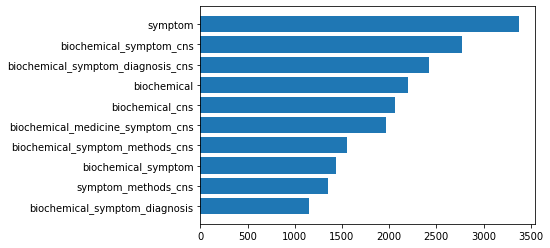

In [ ]:
# figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots()

ax.barh(*zip(*dict(itertools.islice(common_freq.items(), 10)).items()))
ax.invert_yaxis() 
plt.show()

## Dynamic analysis

In [ ]:
df_specific.groupby('Y').count()['Id']

Y
2015    4369
2016    4617
2017    5075
2018    4868
2019    5538
2020    6435
2021    6640
Name: Id, dtype: int64

In [ ]:
columns = ['biochemical', 'medicine', 'symptom', 'diagnosis', 'methods', 'cns']
df_specific.groupby('Y').sum()[columns]

biochemical  medicine  symptom  diagnosis  methods     cns
Y                                                               
2015       2938.0    1189.0   2932.0     1208.0   1133.0  2515.0
2016       3055.0    1268.0   3111.0     1286.0   1183.0  2664.0
2017       3346.0    1311.0   3372.0     1440.0   1291.0  2944.0
2018       3252.0    1235.0   3272.0     1383.0   1249.0  2839.0
2019       3701.0    1382.0   3661.0     1681.0   1406.0  3208.0
2020       4351.0    1569.0   4305.0     1929.0   1588.0  3621.0
2021       4394.0    1646.0   4486.0     2048.0   1655.0  3809.0

In [ ]:
df_specific.groupby('Y').sum()[columns].div(df_specific.groupby('Y').count()['Id'], axis='index')

biochemical  medicine   symptom  diagnosis   methods       cns
Y                                                                   
2015     0.672465  0.272145  0.671092   0.276493  0.259327  0.575647
2016     0.661685  0.274637  0.673814   0.278536  0.256227  0.576998
2017     0.659310  0.258325  0.664433   0.283744  0.254384  0.580099
2018     0.668036  0.253698  0.672145   0.284100  0.256574  0.583196
2019     0.668292  0.249549  0.661069   0.303539  0.253882  0.579270
2020     0.676146  0.243823  0.668998   0.299767  0.246775  0.562704
2021     0.661747  0.247892  0.675602   0.308434  0.249247  0.573645

In [ ]:
common_freq_years = list()

for year in [2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    df_year = df_specific[df_specific['Y'] == year].reset_index(drop = True)

    common_freq_year = dict()
    columns = ['biochemical', 'medicine', 'symptom', 'diagnosis', 'methods', 'cns']

    for i in range(len(df_year)):
        line = '' 
        for col in columns: 
            if df_year.loc[i, col]:
                if line == '':
                    line = line + col
                else:
                    line = line + '_' + col 
        if line in common_freq_year:
            common_freq_year[line] += 1
        else:
            common_freq_year[line] = 1

    common_freq_years.append(common_freq_year)

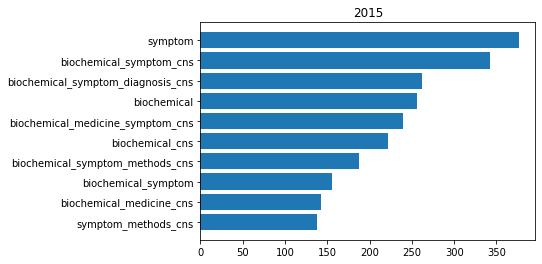

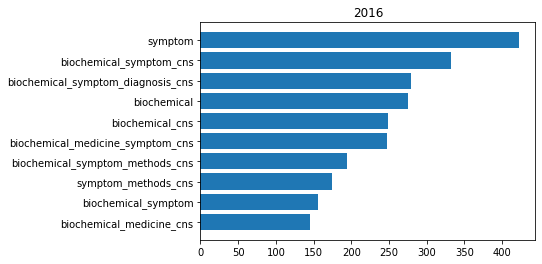

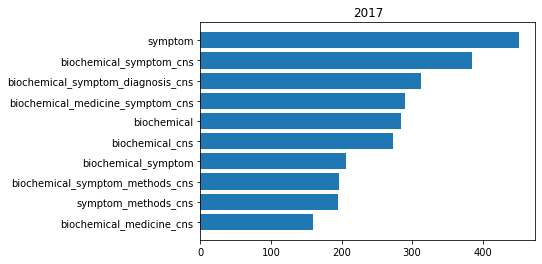

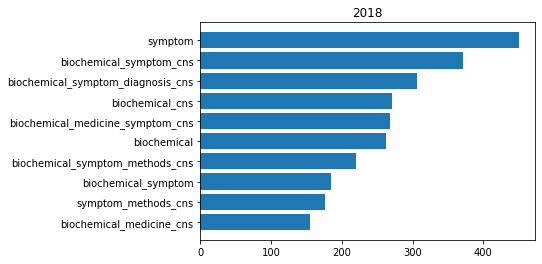

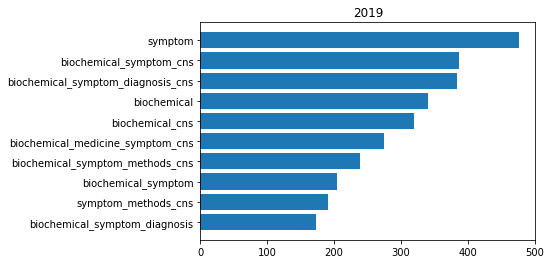

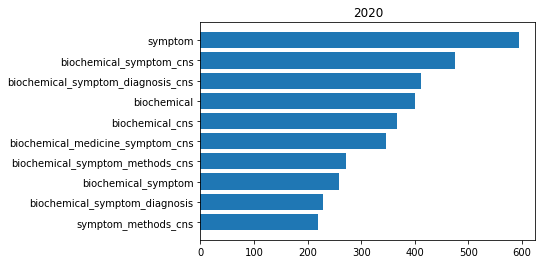

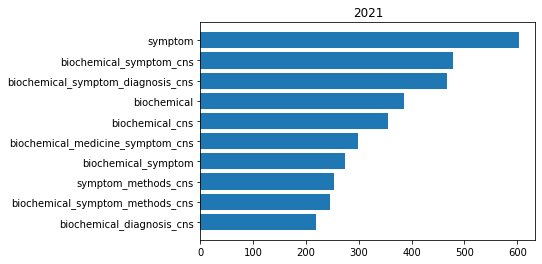

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
for i, year_freq in enumerate(common_freq_years):
    year_freq = dict(sorted(year_freq.items(), key=lambda item: item[1], reverse = True))

    fig, ax = plt.subplots()
    ax.set_title(years[i])
    ax.barh(*zip(*dict(itertools.islice(year_freq.items(), 10)).items()))
    ax.invert_yaxis() 
    plt.show()

## Modelling in specific topics

для каждой темы сделать отдельно моделирование и выделить 

In [ ]:
['biochemical', 'medicine', 'symptom', 'diagnosis', 'methods', 'cns']

In [ ]:
df_biochemical = df_specific[df_specific['biochemical'] == 1].reset_index(drop = True)

common_dictionary_biochemical = Dictionary(df_biochemical['specific_annotation_words'])
common_corpus_biochemical = [common_dictionary_biochemical.doc2bow(text) for text in df_biochemical['specific_annotation_words']]

lda_model_biochemical = gensim.models.ldamodel.LdaModel(corpus=common_corpus_biochemical,
                                           id2word=common_dictionary_biochemical,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_biochemical.save('drive/MyDrive/lda_model_biochemical')
common_dictionary_biochemical.save('drive/MyDrive/lda_biochemical_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_biochemical, common_corpus_biochemical, common_dictionary_biochemical)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.265070 -0.026717       1        1  40.276522
2      0.282252  0.302393       2        1  23.132993
4     -0.030381 -0.242141       3        1  14.407655
1      0.236784 -0.233046       4        1  12.286096
3     -0.223585  0.199511       5        1   9.896733, topic_info=             Term         Freq        Total Category  logprob  loglift
23      alzheimer  4559.000000  4559.000000  Default  30.0000  30.0000
13        protein  9154.000000  9154.000000  Default  29.0000  29.0000
86       dopamine  6848.000000  6848.000000  Default  28.0000  28.0000
16           gene  3782.000000  3782.000000  Default  27.0000  27.0000
9           brain  8114.000000  8114.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
3    hypertension   114.129216   115.005204   Topic5  -4.9632   2.3053
105    selegiline   106.341481   107.212075   Topic5  -5.0339   2.3048
214  homocysteine   101.452580   102.324693   Topic5  -5.0809   2.3044
5    osteoporosis   103.774406   104.668974   Topic5  -5.0583   2.3044
86       dopamine  1726.291396  6848.080574   Topic5  -2.2468   0.9350

[192 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
195       5  0.995036  acetylcholine
25        1  0.999883       activity
189       4  0.998911      adenosine
78        4  0.993198            aid
141       5  0.997435       akinesia
...     ...       ...            ...
51        3  0.998823         tremor
247       4  0.992382   triglyceride
74        2  0.997612          tumor
36        1  0.998088      ubiquitin
63        3  0.999050          updrs

[163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

In [ ]:
df_medicine = df_specific[df_specific['medicine'] == 1].reset_index(drop = True)

common_dictionary_medicine = Dictionary(df_medicine['specific_annotation_words'])
common_corpus_medicine = [common_dictionary_medicine.doc2bow(text) for text in df_medicine['specific_annotation_words']]

lda_model_medicine = gensim.models.ldamodel.LdaModel(corpus=common_corpus_medicine,
                                           id2word=common_dictionary_medicine,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_medicine.save('drive/MyDrive/lda_model_medicine')
common_dictionary_medicine.save('drive/MyDrive/lda_medicine_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_medicine, common_corpus_medicine, common_dictionary_medicine)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.209353 -0.016924       1        1  29.693973
1      0.255026 -0.209842       2        1  28.508399
0     -0.182074 -0.159594       3        1  23.088757
2     -0.337718 -0.016765       4        1  10.355746
4      0.055413  0.403125       5        1   8.353125, topic_info=             Term         Freq        Total Category  logprob  loglift
50       levodopa  2619.000000  2619.000000  Default  30.0000  30.0000
5           brain  2714.000000  2714.000000  Default  29.0000  29.0000
3        activity  2272.000000  2272.000000  Default  28.0000  28.0000
26          nigra  1745.000000  1745.000000  Default  27.0000  27.0000
73    stimulation   822.000000   822.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
296       kinesia     3.578140     4.448546   Topic5  -7.3707   2.2648
351     dysphonia     2.741866     4.029720   Topic5  -7.6369   2.0975
244  cerebrolysin     1.015329     1.865161   Topic5  -8.6304   1.8744
362    filgrastim     6.066365    12.713106   Topic5  -6.8428   1.7427
5           brain   661.509772  2714.693398   Topic5  -2.1511   1.0706

[199 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
155       3  0.990250  acetylcholine
3         1  0.962223       activity
3         2  0.037398       activity
167       3  0.992430      adenosine
90        5  0.996555       akinesia
...     ...       ...            ...
74        3  0.995136     tomography
75        3  0.998946         tremor
79        2  0.996523          tumor
154       1  0.988352      ubiquitin
33        3  0.999140          updrs

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

In [ ]:
df_symptom = df_specific[df_specific['symptom'] == 1].reset_index(drop = True)

common_dictionary_symptom = Dictionary(df_symptom['specific_annotation_words'])
common_corpus_symptom = [common_dictionary_symptom.doc2bow(text) for text in df_symptom['specific_annotation_words']]

lda_model_symptom = gensim.models.ldamodel.LdaModel(corpus=common_corpus_symptom,
                                           id2word=common_dictionary_symptom,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_symptom.save('drive/MyDrive/lda_model_symptom')
common_dictionary_symptom.save('drive/MyDrive/lda_symptom_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_symptom, common_corpus_symptom, common_dictionary_symptom)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.116343  0.283981       1        1  33.570753
2      0.060672 -0.331141       2        1  21.627678
1      0.146185  0.135782       3        1  21.306243
0      0.118665 -0.128373       4        1  18.884578
4     -0.441864  0.039750       5        1   4.610749, topic_info=            Term         Freq        Total Category  logprob  loglift
20     cognitive  6463.000000  6463.000000  Default  30.0000  30.0000
27      activity  6290.000000  6290.000000  Default  29.0000  29.0000
91      dopamine  4538.000000  4538.000000  Default  28.0000  28.0000
4       movement  3563.000000  3563.000000  Default  27.0000  27.0000
18       protein  4708.000000  4708.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
257  hypersomnia     6.635812     7.520803   Topic5  -6.9703   2.9516
183      amnesia     4.340841     5.261496   Topic5  -7.3947   2.8844
232        fxtas     2.407505     3.278678   Topic5  -7.9842   2.7679
315   cordifolia     5.568482     9.058253   Topic5  -7.1457   2.5902
366    sarizotan     4.555351    10.508705   Topic5  -7.3465   2.2409

[192 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
198       2  0.997189    acetylcholine
27        3  0.999869         activity
205       3  0.997936        adenosine
142       2  0.998557         akinesia
82        5  0.995860           allele
...     ...       ...              ...
77        3  0.998202       tomography
78        3  0.996320  transplantation
7         2  0.999490           tremor
80        1  0.999312            tumor
66        2  0.999619            updrs

[172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

In [ ]:
df_diagnosis = df_specific[df_specific['diagnosis'] == 1].reset_index(drop = True)

common_dictionary_diagnosis = Dictionary(df_diagnosis['specific_annotation_words'])
common_corpus_diagnosis = [common_dictionary_diagnosis.doc2bow(text) for text in df_diagnosis['specific_annotation_words']]

lda_model_diagnosis = gensim.models.ldamodel.LdaModel(corpus=common_corpus_diagnosis,
                                           id2word=common_dictionary_diagnosis,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_diagnosis.save('drive/MyDrive/lda_model_diagnosis')
common_dictionary_diagnosis.save('drive/MyDrive/lda_diagnosis_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_diagnosis, common_corpus_diagnosis, common_dictionary_diagnosis)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.024118  0.264861       1        1  40.746263
0     -0.271572  0.177804       2        1  32.900411
1      0.251181 -0.087385       3        1   8.973003
3     -0.217015 -0.354283       4        1   8.744069
4      0.261524 -0.000997       5        1   8.636254, topic_info=            Term         Freq        Total Category  logprob  loglift
2      sclerosis  1856.000000  1856.000000  Default  30.0000  30.0000
13       protein  3624.000000  3624.000000  Default  29.0000  29.0000
1          brain  3781.000000  3781.000000  Default  28.0000  28.0000
15   amyotrophic  1359.000000  1359.000000  Default  27.0000  27.0000
0      alzheimer  6036.000000  6036.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
32      postural   179.638287   223.842531   Topic5  -3.5975   2.2292
31         nigra   248.270559  1106.704689   Topic5  -3.2740   0.9546
22      movement   169.949328   928.450182   Topic5  -3.6530   0.7512
131     midbrain    92.794271   317.214162   Topic5  -4.2581   1.2200
118      putamen    56.817669   146.723238   Topic5  -4.7486   1.5005

[203 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
232       4  0.995176  acetylcholine
14        2  0.999442       activity
181       4  0.995302      adenosine
60        5  0.998612            aid
128       3  0.988650       akinesia
...     ...       ...            ...
127       4  0.935805     tryptophan
255       4  0.956764        tubulin
56        2  0.998118          tumor
96        2  0.997212      ubiquitin
169       5  0.996765          updrs

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

In [ ]:
df_methods = df_specific[df_specific['methods'] == 1].reset_index(drop = True)

common_dictionary_methods = Dictionary(df_methods['specific_annotation_words'])
common_corpus_methods = [common_dictionary_methods.doc2bow(text) for text in df_methods['specific_annotation_words']]

lda_model_methods = gensim.models.ldamodel.LdaModel(corpus=common_corpus_methods,
                                           id2word=common_dictionary_methods,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_methods.save('drive/MyDrive/lda_model_methods')
common_dictionary_methods.save('drive/MyDrive/lda_methods_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_methods, common_corpus_methods, common_dictionary_methods)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.342542  0.189205       1        1  52.936715
4      0.152734 -0.300910       2        1  20.047260
0     -0.271015  0.155713       3        1  14.280340
3     -0.159202 -0.217608       4        1   9.099976
1     -0.065060  0.173601       5        1   3.635708, topic_info=             Term         Freq        Total Category  logprob  loglift
31      cognitive  1946.000000  1946.000000  Default  30.0000  30.0000
41       dopamine  1472.000000  1472.000000  Default  29.0000  29.0000
8           brain  3984.000000  3984.000000  Default  28.0000  28.0000
6     stimulation  3773.000000  3773.000000  Default  27.0000  27.0000
10    dysfunction  1287.000000  1287.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
303  triglyceride     1.002517     3.618693   Topic5  -7.6506   2.0308
276    olanzapine     0.300828     1.184015   Topic5  -8.8543   1.9442
275   pardoprunox     0.287573     1.174689   Topic5  -8.8994   1.9071
168     nilotinib     0.447451     3.332959   Topic5  -8.4573   1.3063
15      exenatide     0.391130     5.652225   Topic5  -8.5918   0.6436

[200 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
20        1  0.999051      activity
141       3  0.988808     adenosine
78        3  0.990307           aid
108       1  0.996570      akinesia
159       2  0.977563        allele
...     ...       ...           ...
303       2  0.276343  triglyceride
303       4  0.276343  triglyceride
303       5  0.276343  triglyceride
37        4  0.993609         tumor
19        1  0.999810         updrs

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

In [ ]:
df_cns = df_specific[df_specific['cns'] == 1].reset_index(drop = True)

common_dictionary_cns = Dictionary(df_cns['specific_annotation_words'])
common_corpus_cns = [common_dictionary_cns.doc2bow(text) for text in df_cns['specific_annotation_words']]

lda_model_cns = gensim.models.ldamodel.LdaModel(corpus=common_corpus_cns,
                                           id2word=common_dictionary_cns,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_cns.save('drive/MyDrive/lda_model_cns')
common_dictionary_cns.save('drive/MyDrive/lda_cns_dictionary')

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_cns, common_corpus_cns, common_dictionary_cns)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.226863  0.028349       1        1  34.218266
3      0.087507  0.265674       2        1  30.987714
2     -0.380736 -0.145849       3        1  12.927050
1      0.186776 -0.335470       4        1  12.677557
4     -0.120410  0.187296       5        1   9.189412, topic_info=            Term          Freq         Total Category  logprob  loglift
1          brain  11692.000000  11692.000000  Default  30.0000  30.0000
0      alzheimer   3273.000000   3273.000000  Default  29.0000  29.0000
36   stimulation   3188.000000   3188.000000  Default  28.0000  28.0000
14       protein   5624.000000   5624.000000  Default  27.0000  27.0000
87      dopamine   5258.000000   5258.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
186    tolcapone     21.804688     22.642720   Topic5  -6.4544   2.3494
321    magnesium     21.205710     22.093569   Topic5  -6.4822   2.3461
45          lewy    681.628644   1460.973883   Topic5  -3.0120   1.6247
16     cognitive    527.834468   3021.323171   Topic5  -3.2677   0.6425
55       amyloid     72.891442    588.971106   Topic5  -5.2475   0.2977

[200 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
22        1  0.840613         activity
22        2  0.159410         activity
175       2  0.998202        adenosine
145       3  0.994487              aid
157       5  0.995968         akinesia
...     ...       ...              ...
73        1  0.998155  transplantation
49        5  0.999024           tremor
75        3  0.997319            tumor
33        3  0.998533        ubiquitin
63        4  0.999112            updrs

[174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])